In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import seaborn as sns
import unidecode, re
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score
from scipy import *
from sklearn.feature_selection import SelectKBest, f_regression
from catboost import CatBoostClassifier
import lightgbm as lgb
import joblib
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

my_font = dict(
            family="Courier New, monospace",
            size=18,
            color="Black",
            variant="small-caps",
) 

df = pd.read_csv("data/train.csv")
df_test = pd.read_csv("data/test.csv")


In [43]:
x = df.isna().sum().reset_index(name='count').sort_values(by='count', ascending=False)
x['pecentage_of_missing_data'] = (x['count'] / len(df))*100
x

,index,count,pecentage_of_missing_data
16,OBES_IMC,483795,97.085206
10,PUERPERA,298765,59.954447
18,SIND_DOWN,298085,59.817988
19,HEPATICA,297733,59.747351
13,IMUNODEPRE,295546,59.308476
14,RENAL,292734,58.744180
12,PNEUMOPATI,292402,58.677557
15,OBESIDADE,290862,58.368518
27,FADIGA,268807,53.942647
11,DIABETES,252391,50.648379


In [104]:
df_no_nulls = df.copy()
df_no_nulls['total_chronic_cormodity'] = ((df_no_nulls[["OBESIDADE", 
                                                        "RENAL", 
                                                        "CARDIOPATI",
                                                        "IMUNODEPRE", 
                                                        "DIABETES", 
                                                        "PNEUMOPATI",
                                                        "HEPATICA",
                                                        "SIND_DOWN"]] == 1.0).sum(axis=1))

df_no_nulls['total_temporary_cormodity'] = (df_no_nulls[["FEBRE",
                                                        "TOSSE",
                                                        "PUERPERA",
                                                        "GARGANTA",
                                                        "DESC_RESP",
                                                        "DIARREIA",
                                                        "VOMITO",
                                                        "FADIGA",
                                                        "SATURACAO",
                                                        "DISPNEIA"]]== 1.0).sum(axis=1)

In [91]:
class DataPreprocessor:
    def __init__(self, dataframe):
        self.df = dataframe.copy()
    
    def fill_rows_with_ints(self, columns_to_fill, missing_value=0):
        for col in columns_to_fill:
            if col in self.df.columns:
                #self.df[col] = self.df[col].fillna(missing_value)
                self.df[col] = self.df[col].astype(int)
        return self.df

    def fill_null_rows(self, columns_to_fill, missing_value):
        for col in columns_to_fill:
            if col in self.df.columns:
                #self.df[col] = self.df[col].fillna(missing_value)
                self.df[col] = self.df[col].astype('category')

        return self.df



preprocessor = DataPreprocessor(df_no_nulls)

columns_to_fill = df_no_nulls.select_dtypes(['float']).columns.tolist()

df_2 = preprocessor.fill_null_rows(columns_to_fill, 9)

columns_to_fill = [
                   "OBESIDADE", 
                   "RENAL", 
                   "CARDIOPATI",
                   "IMUNODEPRE", 
                   "DIABETES", 
                   "PNEUMOPATI",
                   "HEPATICA",
                   "FEBRE",
                   "TOSSE",
                   "GARGANTA",
                   "DESC_RESP",
                   "DIARREIA",
                   "VOMITO",
                   "FADIGA",
                   "SATURACAO",
                   "DISPNEIA",
                   "CS_RACA",
                   "CS_ZONA",
                   "VACINA",
                   "CS_ESCOL_N",
                   "FATOR_RISC",
                   "SIND_DOWN",
                   "CO_RG_RESI",
                   "PUERPERA",
                   "CS_SEXO",
                   "SG_UF",
                   "EVOLUCAO",
                   "CS_GESTANT"
                  ] # 22 columns 


df_2["CS_GESTANT"] =df_2["CS_GESTANT"].astype('category') 

In [105]:
numeric_cols = df.select_dtypes(include=np.number).columns

imputer = SimpleImputer(strategy='most_frequent')

df_no_nulls[numeric_cols] = imputer.fit_transform(df_no_nulls[numeric_cols])

In [106]:
df_no_nulls.drop(columns={"DT_NOTIFIC", "ID_MN_RESI","OBES_IMC", "CO_RG_RESI", 'CS_SEXO', 'SG_UF'}, inplace=True)

In [107]:
preprocessor = DataPreprocessor(df_no_nulls)

columns_to_fill = df_no_nulls.select_dtypes(['float', 'object']).columns.tolist()

df_2 = preprocessor.fill_null_rows(columns_to_fill, 9)

df_2["CS_GESTANT"] = df_2["CS_GESTANT"].astype('category') 

df_2['NU_IDADE_N'] = df_2['NU_IDADE_N'].astype(int) 

In [109]:
X = df_no_nulls.drop(columns={'EVOLUCAO'})
y = df_no_nulls['EVOLUCAO']

In [112]:

X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = .2, random_state=32)


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=32)


cat_features = X.select_dtypes(['category', 'object']).columns.tolist()
params = {
    'iterations':1000,
    'learning_rate':0.05,
    'depth':6,
    'eval_metric':'TotalF1',
    'random_seed':42,
    'early_stopping_rounds':20,
    'verbose': 50
}
ctb = CatBoostClassifier(
  **params
)

ctb.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=cat_features
)


# ctb.fit(X_train, y_train,cat_features=cat_features)
y_pred = ctb.predict_proba(X_valid)[:, 1]
print("Validation AUC:", roc_auc_score(y_valid, y_pred))

0:	learn: 0.6925937	test: 0.6936917	best: 0.6936917 (0)	total: 74.9ms	remaining: 1m 14s
50:	learn: 0.7088016	test: 0.7089412	best: 0.7089412 (50)	total: 3.25s	remaining: 1m
100:	learn: 0.7134187	test: 0.7132327	best: 0.7132327 (100)	total: 6.16s	remaining: 54.8s
150:	learn: 0.7160424	test: 0.7153309	best: 0.7154845 (146)	total: 8.95s	remaining: 50.3s
200:	learn: 0.7177114	test: 0.7166265	best: 0.7166265 (200)	total: 12.2s	remaining: 48.4s
250:	learn: 0.7185864	test: 0.7174206	best: 0.7174206 (250)	total: 15.1s	remaining: 45.1s
300:	learn: 0.7196972	test: 0.7183110	best: 0.7183466 (290)	total: 18.1s	remaining: 42.1s
350:	learn: 0.7203812	test: 0.7188758	best: 0.7188758 (350)	total: 21s	remaining: 38.8s
400:	learn: 0.7209154	test: 0.7191684	best: 0.7192025 (399)	total: 23.8s	remaining: 35.6s
450:	learn: 0.7212812	test: 0.7192511	best: 0.7193324 (440)	total: 26.6s	remaining: 32.4s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7194079794
bestIteration = 464

Shrink mo

ctb acurracy: 72.91%

Classification report
              precision    recall  f1-score   support

         0.0       0.76      0.85      0.80     65298
         1.0       0.64      0.50      0.56     34366

    accuracy                           0.73     99664
   macro avg       0.70      0.67      0.68     99664
weighted avg       0.72      0.73      0.72     99664



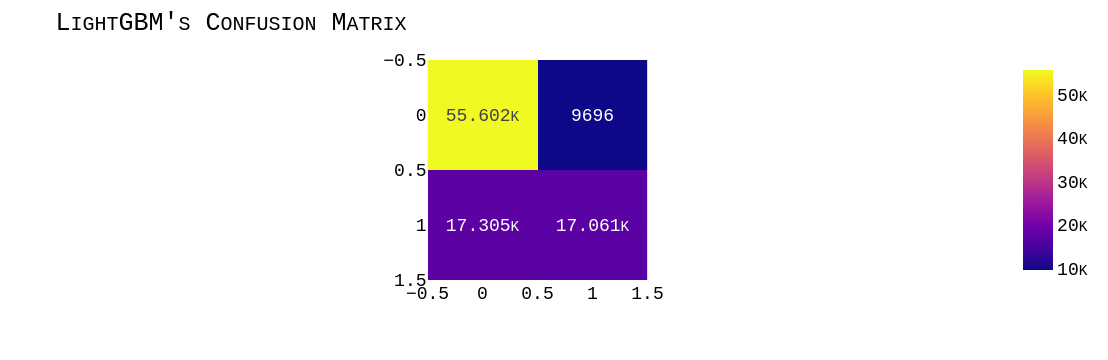

In [114]:
preds = ctb.predict(X_test)

accuracy = ctb.score(X_test, y_test)


print(f"ctb acurracy: {accuracy*100:.2f}%")
print("\nClassification report")
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
fig = px.imshow(cm, text_auto=True).update_layout(title={"text": "LightGBM's Confusion Matrix"}, font=my_font).show()



In [117]:

from catboost import Pool, cv

train_pool = Pool(X, label=y, cat_features=cat_features)

params = {
    'iterations': 1000,
    'learning_rate': 0.05,
    'depth': 6,
    'eval_metric': 'TotalF1',
    'random_seed': 42,
    'loss_function': 'Logloss',

}
cv_results = cv(
    params=params,
    pool=train_pool,
    fold_count=1,
    early_stopping_rounds=50,
    verbose=50,
    stratified=True
)

print("Best CV AUC:", cv_results['test-AUC-mean'].max())

Training on fold [0/1]


CatBoostError: catboost/libs/data/quantization.cpp:2420: All features are either constant or ignored.